# 1. Import required libraries

Install optional packages if missing (yfinance used for convenience)

In [26]:
import subprocess
import sys
from pathlib import Path

# Load environment variables from .env file
from dotenv import load_dotenv
load_dotenv()

# Install required packages from pyproject.toml dependencies
required = ["pandas", "numpy", "matplotlib", "yfinance"]
for pkg in required:
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker

# Add model package to path (works for shared/cloned repos)
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

%matplotlib inline

# Stage 1: Stock Analytics

In [4]:
from model.orchestration.stock_analytics_orchestrator import StockAnalyticsOrchestrator

In [5]:
# Instantiate orchestrator for SNOW
TICKER = "SNOW"
orchestrator = StockAnalyticsOrchestrator(TICKER)

## get_technical_metrics
Retrieve technical metrics from the `StockAnalyticsOrchestrator` and print selected values.


In [6]:
tech = orchestrator.get_technical_metrics()
hist = orchestrator.stock_data_provider.history()

print(f"Technical Metrics for {TICKER}")
print(f"Current Price: ${tech.get('current_price'):.2f}")
print(f"52-Week High: ${tech.get('price_252d_high'):.2f}")
print(f"52-Week Low: ${tech.get('price_252d_low'):.2f}")
print(f"Historical Volatility: {tech.get('historical_volatility_annual'):.2%}")
print(f"Bollinger Position: {tech.get('bollinger_position_20d_2std'):.2f}")
print(f"\nData points available: {len(hist)}")

Technical Metrics for SNOW
Current Price: $192.70
52-Week High: $280.67
52-Week Low: $120.10
Historical Volatility: 49.97%
Bollinger Position: -0.00

Data points available: 251


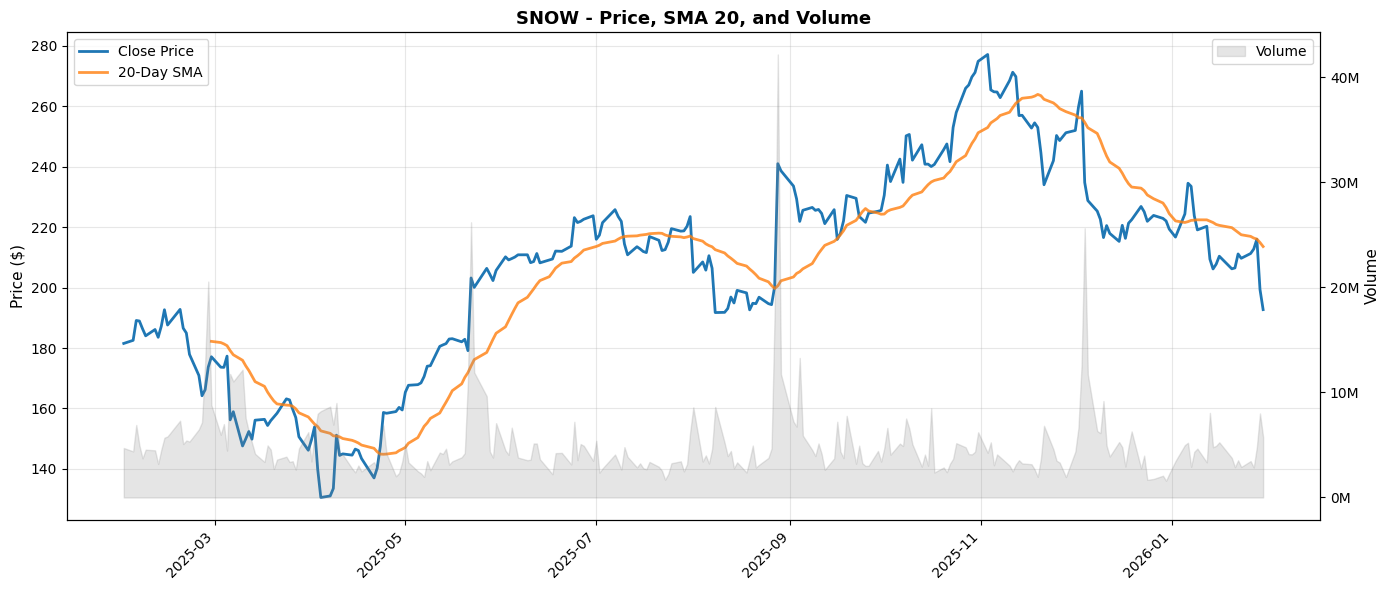

In [7]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Price and SMA
ax1.plot(hist.index, hist['Close'], label='Close Price', linewidth=2, color='#1f77b4')
ax1.plot(hist.index, hist['Close'].rolling(20).mean(), label='20-Day SMA', linewidth=2, color='#ff7f0e', alpha=0.8)
ax1.set_ylabel('Price ($)', fontsize=11)
ax1.tick_params(axis='y')
ax1.grid(True, alpha=0.3)

# Volume on secondary axis
ax2 = ax1.twinx()
ax2.fill_between(hist.index, hist['Volume'], alpha=0.2, color='gray', label='Volume')
ax2.set_ylabel('Volume', fontsize=11)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x/1e6:.0f}M'))

# Format x-axis as dates
ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
fig.autofmt_xdate(rotation=45)

ax1.set_title(f'{TICKER} - Price, SMA 20, and Volume', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

## Financial Metrics
Retrieve financial metrics and show primary accounting values.


In [8]:
fin = orchestrator.get_financial_metrics()
income_df = orchestrator.stock_data_provider.get_income_stmt()
balance_df = orchestrator.stock_data_provider.get_balance_sheet()

print(f"Financial Metrics for {TICKER}")
print(f"TTM Revenue: ${fin.get('ttm_revenue')/1e9:.2f}B")
print(f"Revenue Growth YoY: {fin.get('revenue_growth_yoy'):.2%}")
print(f"Gross Margin: {fin.get('gross_margin_q'):.2%}")
print(f"Operating Margin: {fin.get('operating_margin_q'):.2%}")
print(f"Net Profit Margin: {fin.get('net_profit_margin_q'):.2%}")
print(f"ROE: {fin.get('return_on_equity_q'):.2%}")
print(f"Debt/Equity: {fin.get('debt_to_equity_q'):.2f}x")

Financial Metrics for SNOW
TTM Revenue: $4.39B
Revenue Growth YoY: 28.75%
Gross Margin: 67.77%
Operating Margin: -27.16%
Net Profit Margin: -24.24%
ROE: -63.27%
Debt/Equity: 1.26x


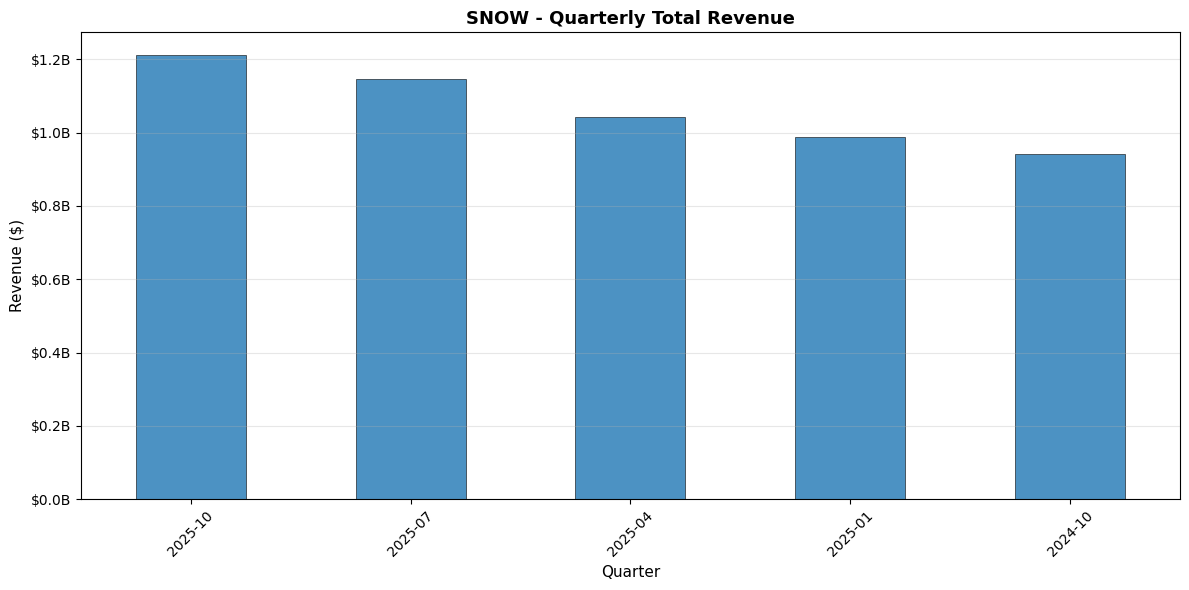

In [9]:
if 'TotalRevenue' in income_df.index:
    rev_series = pd.to_numeric(income_df.loc['TotalRevenue'])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rev_series.plot(kind='bar', ax=ax, color='#1f77b4', alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Format y-axis as billions
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x/1e9:.1f}B'))
    ax.set_ylabel('Revenue ($)', fontsize=11)
    ax.set_xlabel('Quarter', fontsize=11)
    ax.set_title(f'{TICKER} - Quarterly Total Revenue', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Format x-axis labels as dates
    if isinstance(rev_series.index[0], pd.Timestamp):
        ax.set_xticklabels([d.strftime('%Y-%m') for d in rev_series.index], rotation=45)
    
    plt.tight_layout()
    plt.show()

## Volume Positioning Metrics

In [10]:
volume = orchestrator.get_volume_positioning_metrics()

print(f"Volume Positioning for {TICKER}")
if volume.get('average_daily_volume'):
    print(f"Average Daily Volume (30d): {volume.get('average_daily_volume'):,.0f}")
if volume.get('latest_volume'):
    print(f"Latest Volume: {volume.get('latest_volume'):,.0f}")
if volume.get('volume_trend_ratio_20d'):
    print(f"Volume Trend Ratio (20d): {volume.get('volume_trend_ratio_20d'):.2f}")
if volume.get('abnormal_volume_20d') is not None:
    print(f"Abnormal Volume (20d): {volume.get('abnormal_volume_20d'):.2%}")
if volume.get('volume_volatility_20d'):
    print(f"Volume Volatility (20d): {volume.get('volume_volatility_20d'):.4f}")

Volume Positioning for SNOW
Average Daily Volume (30d): 5,108,163
Volume Trend Ratio (20d): 1.28
Abnormal Volume (20d): 27.90%
Volume Volatility (20d): 0.4645


## Peer Metrics

In [11]:
peer_metrics = orchestrator.get_peer_metrics()
peer_prices = orchestrator.peer_discovery_provider.get_peers_stock_data()

print(f"Peer Relative Performance (63d window)")
print(f"Excess Return vs Peers: {peer_metrics.get('rolling_excess_return_63d_vs_peers'):.2%}")
print(f"Outperformance Frequency: {peer_metrics.get('outperformance_frequency_63d'):.2%}")
print(f"Relative Recovery Time: {peer_metrics.get('relative_recovery_time_days'):.0f} days")
print(f"\nTop Peers: {list(peer_prices.keys())[:5]}")

Peer Relative Performance (63d window)
Excess Return vs Peers: -0.41%
Outperformance Frequency: 52.38%
Relative Recovery Time: -90 days

Top Peers: ['IFNNF', 'TEL', 'IFNNY', 'MSI', 'MRVL']


## Stock Information & Company Data

In [12]:
info = orchestrator.stock_data_provider.get_info()

# Display key company info
key_fields = ['longName', 'sector', 'industry', 'website', 'fullTimeEmployees', 
              'marketCap', 'enterpriseValue', 'trailingPE', 'forwardPE', 'beta']

print(f"Company Information for {TICKER}")
for field in key_fields:
    value = info.get(field)
    if value:
        if isinstance(value, (int, float)) and value > 1e6:
            print(f"{field}: ${value/1e9:.2f}B" if value > 1e9 else f"{field}: ${value/1e6:.2f}M")
        else:
            print(f"{field}: {value}")

Company Information for SNOW
longName: Snowflake Inc.
sector: Technology
industry: Software - Application
website: https://www.snowflake.com
fullTimeEmployees: 9023
marketCap: $65.94B
enterpriseValue: $65.27B
forwardPE: 118.03837
beta: 1.147


## Macro Sensitivity

In [13]:
macro = orchestrator.get_macro_metrics()

# Show top macro sensitivities
macro_betas = {k: v for k, v in macro.items() if 'rolling_beta' in k}
if macro_betas:
    sorted_betas = sorted(macro_betas.items(), key=lambda x: abs(x[1]), reverse=True)
    print(f"Top Macro Economic Sensitivities (63d rolling beta) for {TICKER}:")
    for factor, beta in sorted_betas[:5]:
        factor_name = factor.replace('macro_rolling_beta_63d_vs_', '')
        print(f"  {factor_name}: {beta:.3f}")

Top Macro Economic Sensitivities (63d rolling beta) for SNOW:
  PAYEMS: 12.189
  INDPRO: 1.017
  CPIAUCSL: 0.983
  GS2: -0.405
  GS10: 0.101


## Thesis Context

In [14]:
thesis_ctx = orchestrator.get_thesis_context()

print(f"Thesis Quantitative Context for {TICKER}")
print(f"Revenue Growth YoY: {thesis_ctx.revenue_growth_yoy:.2%}" if thesis_ctx.revenue_growth_yoy else "Revenue Growth YoY: N/A")
print(f"Earnings Growth YoY: {thesis_ctx.earnings_growth_yoy:.2%}" if thesis_ctx.earnings_growth_yoy else "Earnings Growth YoY: N/A")
print(f"Forward P/E: {thesis_ctx.forward_pe:.1f}x" if thesis_ctx.forward_pe else "Forward P/E: N/A")
print(f"Analyst Target Price Upside: {thesis_ctx.analyst_target_price_upside:.2%}" if thesis_ctx.analyst_target_price_upside else "Analyst Target Price Upside: N/A")

print("\n" + "="*60)
print("QUANTITATIVE CONTEXT SUMMARY")
print("="*60)
print(thesis_ctx.to_prompt_context())

Thesis Quantitative Context for SNOW
Revenue Growth YoY: 28.75%
Earnings Growth YoY: 9.35%
Forward P/E: 118.0x
Analyst Target Price Upside: 46.18%

QUANTITATIVE CONTEXT SUMMARY
QUANTITATIVE CONTEXT FOR SNOW (as of 2026-02-02)
NOTE: These metrics provide supplementary context only. 
Your independent research and analysis should take precedence.

GROWTH TRAJECTORY:
  • Revenue Growth (YoY): +28.7%
  • Earnings Growth (YoY): +9.4%
  • FCF Growth (YoY): +45.2%

MARGIN TRENDS:
  • Gross Margin: 67.8% (+1.8pp vs year ago)
  • Operating Margin: -27.2% (+11.6pp vs year ago)

VALUATION CONTEXT:
  • Forward P/E: 118.0x
  • Price vs 52w High: 68.7%

CAPITAL EFFICIENCY:
  • ROE: -63.3% (-2.7pp vs year ago)
  • Debt/Equity: 1.26x (+0.37 vs year ago)

ANALYST SENTIMENT:
  • Analyst Rating: Buy (1.57)
  • Target Price Upside: +46.2%
  • Recent Revisions: Down



# Stage 2: Thesis Engineering


Initialize the thesis validation orchestrator and define your thesis narrative.
Note: Stage 2 requires Anthropic API credentials (ANTHROPIC_API_KEY). If not available, the cells will show expected outputs.

In [15]:
from model.orchestration.thesis_validation_orchestrator import ThesisValidationOrchestrator


In [24]:
orchestrator_tv = ThesisValidationOrchestrator(TICKER)

# Define sample thesis narrative and company context
thesis_narrative = """
Snowflake is well-positioned to benefit from enterprise cloud data consolidation trends.
The company's unique architecture enables seamless data sharing and collaboration.
Strong revenue growth and improving operational efficiency support long-term value creation.
"""

company_context = """
Snowflake Inc. is a cloud-native data platform enabling data sharing and analytics.
Founded in 2012, headquartered in San Mateo, California.
Primary revenue from cloud infrastructure consumption and subscription.
"""

print(f"Thesis Validation Setup for {TICKER}")
print(f"\nThesis: {thesis_narrative.strip()}")
print(f"\nCompany Context: {company_context.strip()}")

Thesis Validation Setup for SNOW

Thesis: Snowflake is well-positioned to benefit from enterprise cloud data consolidation trends.
The company's unique architecture enables seamless data sharing and collaboration.
Strong revenue growth and improving operational efficiency support long-term value creation.

Company Context: Snowflake Inc. is a cloud-native data platform enabling data sharing and analytics.
Founded in 2012, headquartered in San Mateo, California.
Primary revenue from cloud infrastructure consumption and subscription.


### Stage 2.1: Narrative Decomposition Graph (NDG)

Decompose thesis into key assumptions, vulnerabilities, and relationships.

In [27]:
try:
    ndg_output = orchestrator_tv.ndg.run(
        thesis_narrative=thesis_narrative,
        company_context=company_context,
        quantitative_context=thesis_ctx
    )
    print(f"NDG Analysis Complete for {TICKER}")
    print(f"Nodes (key assumptions): {len(ndg_output.nodes)}")
    print(f"Edges (relationships): {len(ndg_output.edges)}")
    if ndg_output.nodes:
        print(f"\nSample assumptions:")
        for node in list(ndg_output.nodes)[:3]:
            print(f"  - {node.label}: {node.description[:80]}...")
except Exception as e:
    print(f"NDG requires Anthropic API key. Error: {type(e).__name__}")

NDG requires Anthropic API key. Error: AuthenticationError


### Stage 2.2: Red Team (Adversarial Challenges)

Generate challenges and counterarguments to stress-test the thesis.

In [28]:
try:
    if 'ndg_output' in locals():
        red_team_output = orchestrator_tv.red_team.run(ndg=ndg_output, company_context=company_context)
        print(f"Red Team Analysis Complete for {TICKER}")
        print(f"Challenges generated: {len(red_team_output.challenges)}")
        if red_team_output.challenges:
            print(f"\nSample challenges:")
            for challenge in red_team_output.challenges[:3]:
                print(f"  - {challenge.challenge[:100]}...")
    else:
        print("Run NDG stage first to enable Red Team analysis")
except Exception as e:
    print(f"Red Team requires Anthropic API key. Error: {type(e).__name__}")

Run NDG stage first to enable Red Team analysis


### Stage 2.3: Counterfactual Scenario Engine (CRE)

Generate alternative scenarios and their implications.

In [29]:
try:
    if 'ndg_output' in locals() and 'red_team_output' in locals():
        cre_output = orchestrator_tv.cre.run(
            ndg=ndg_output,
            red_team=red_team_output,
            company_context=company_context,
            quantitative_context=thesis_ctx
        )
        print(f"Counterfactual Scenario Analysis Complete for {TICKER}")
        print(f"Scenarios generated: {len(cre_output.scenario_set.scenarios)}")
        if cre_output.scenario_set.scenarios:
            print(f"\nScenario types:")
            for scenario in cre_output.scenario_set.scenarios[:3]:
                print(f"  - {scenario.scenario_type}: {scenario.description[:80]}...")
    else:
        print("Run NDG and Red Team stages first to enable CRE analysis")
except Exception as e:
    print(f"CRE requires Anthropic API key. Error: {type(e).__name__}")

Run NDG and Red Team stages first to enable CRE analysis


### Stage 2.4: Financial Translation (FT)

Map scenarios to financial valuations and outcomes.

In [30]:
try:
    if 'cre_output' in locals():
        ft_result = orchestrator_tv.ft.run(cre_output)
        ft_output = ft_result.cre_output
        print(f"Financial Translation Complete for {TICKER}")
        print(f"Valuation scenarios: {len(ft_output.scenario_results)}")
        if ft_output.scenario_results:
            print(f"\nValuation outcomes:")
            for result in ft_output.scenario_results[:3]:
                print(f"  - Scenario: Target Price = ${result.target_price:.2f}" if result.target_price else f"  - Scenario analyzed")
    else:
        print("Run CRE stage first to enable Financial Translation")
except Exception as e:
    print(f"FT requires Anthropic API key. Error: {type(e).__name__}")

Run CRE stage first to enable Financial Translation


### Stage 2.5: Thesis Validity Evaluation

Evaluate thesis status based on rule-based assessments.

In [31]:
try:
    if all(k in locals() for k in ['ft_output', 'red_team_output', 'ndg_output']):
        validity_output = orchestrator_tv.validity_evaluator.run(ft_output, red_team_output, ndg_output)
        print(f"Thesis Validity Evaluation Complete for {TICKER}")
        print(f"Status: {validity_output.status}")
        print(f"Conviction: {validity_output.conviction_level:.2%}" if validity_output.conviction_level else "Conviction: N/A")
        if validity_output.issues:
            print(f"\nKey Issues:")
            for issue in validity_output.issues[:3]:
                print(f"  - {issue}")
    else:
        print("Run prior stages first to enable Validity Evaluation")
except Exception as e:
    print(f"Validity evaluation requires Anthropic API key. Error: {type(e).__name__}")

Run prior stages first to enable Validity Evaluation


### Stage 2.6: Half-Life Estimation (IHLE)

Estimate thesis idea half-life and monitoring cadence.

In [32]:
try:
    if 'ndg_output' in locals():
        ihle_output = orchestrator_tv.ihle.run(ndg=ndg_output, current_macro_context=None)
        print(f"Idea Half-Life Estimation Complete for {TICKER}")
        if ihle_output and ihle_output.half_life_estimate:
            print(f"Estimated Half-Life: {ihle_output.half_life_estimate.estimated_half_life_months} months")
            print(f"Monitoring Cadence: {ihle_output.half_life_estimate.monitoring_cadence}")
            print(f"Severity: {ihle_output.half_life_estimate.severity_level}")
        else:
            print("Half-life estimate unavailable")
    else:
        print("Run NDG stage first to enable Half-Life Estimation")
except Exception as e:
    print(f"IHLE requires Anthropic API key. Error: {type(e).__name__}")

Run NDG stage first to enable Half-Life Estimation


### Stage 2.7: Full Pipeline (Optional)

Run the complete thesis validation pipeline in one call.

In [33]:
print(f"Full Pipeline Execution for {TICKER}")
print("="*60)
print("To run the complete thesis validation pipeline at once:")
print()
print("try:")
print("    final_report = orchestrator_tv.run(")
print("        thesis_narrative=thesis_narrative,")
print("        company_context=company_context,")
print("        quantitative_context=thesis_ctx")
print("    )")
print("    print(f'Final Status: {final_report.status}')")
print("    print(f'Aggregation Score: {final_report.aggregation_score:.2%}')")
print("except Exception as e:")
print("    print(f'Full pipeline requires Anthropic API key')")
print()
print("This orchestrates all 7 stages with proper dependency management.")
print("Individual stages above allow for inspection and iteration.")

Full Pipeline Execution for SNOW
To run the complete thesis validation pipeline at once:

try:
    final_report = orchestrator_tv.run(
        thesis_narrative=thesis_narrative,
        company_context=company_context,
        quantitative_context=thesis_ctx
    )
    print(f'Final Status: {final_report.status}')
    print(f'Aggregation Score: {final_report.aggregation_score:.2%}')
except Exception as e:
    print(f'Full pipeline requires Anthropic API key')

This orchestrates all 7 stages with proper dependency management.
Individual stages above allow for inspection and iteration.
